In [1]:
import ROOT
from IPython.display import Image
import numpy as np
import pandas as pd

Welcome to JupyROOT 6.26/06


In [2]:
# Define some numpy arrays:
run = np.arange(0,10, dtype = np.intc)
event = np.arange(0,10, dtype = np.intc)
entry = np.arange(100,110, dtype = float)

# Start the RDataFrame from numpy arrays.
rq_df = ROOT.RDF.MakeNumpyDataFrame({'run': run, 'event': event,'entry': entry})

# Define new variables (Represents RRQs)
rq_df = rq_df.Define('merged_index','(run+10)+event')

# Return TTree branches as numpy arrays.
output = rq_df.AsNumpy({'merged_index','run', 'event','entry'})

# export output to Pandas DataFrame
df = pd.DataFrame(output)
display(df)


# Save the DataFrame to a root file
rq_df.Snapshot('test','test.root')

,run,event,entry,merged_index
0,0,0,100.0,10
1,1,1,101.0,12
2,2,2,102.0,14
3,3,3,103.0,16
4,4,4,104.0,18
5,5,5,105.0,20
6,6,6,106.0,22
7,7,7,107.0,24
8,8,8,108.0,26
9,9,9,109.0,28


<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x55576cdbbef0>

In [3]:
# Grabbing files (not specific to RDataFrame)
def toFilepath(ID): return f"/cvmfs/data/CDMS/RDataFrame_testing/data/OFResults_{ID}.root"
sourceFiles = map(toFilepath, ['25220213_171932'])
files = [file for file in sourceFiles]
print(files)

chanlist=['NFE', 'NFH', 'NFC1', 'NFC2']
tr={}
tr['NFC1']=1
tr['NFH']=2
tr['NFE']=3
tr['NFC2']=4

['/cvmfs/data/CDMS/RDataFrame_testing/data/OFResults_25220213_171932.root']


# Loading files

In [4]:
df = ROOT.RDataFrame('rqDir/zip1',files)

# Single 1D Histogram

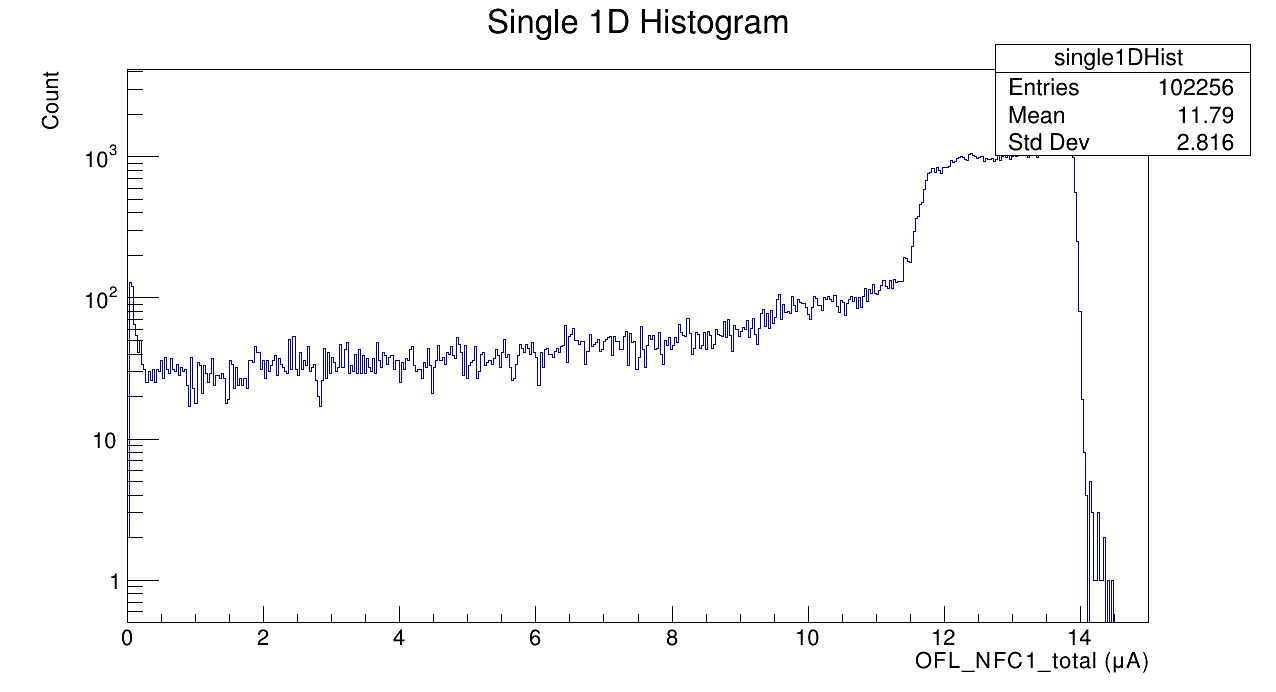

In [5]:
# Create a canvas to draw on, with y-axis logarithmic
single1DCanvas = ROOT.TCanvas("single1DCanvas", "", 1280, 720)
single1DCanvas.SetLogy()

# Create 1D histogram of OFL_NFC1_total
# We plot a filtered version where channel 1 (NFC1) was the triggered detector.
single1DHist = df.Filter("trig_ch == 1").Histo1D(("single1DHist", "Single 1D Histogram", 500, 0, 15),"OFL_NFC1_total")

# single1DHist.SetStats(0) # Nobody asked for a stat box
single1DHist.GetXaxis().SetTitle("\\hbox{OFL_NFC1_total (μA)}") # LaTeX \hbox is a hack to get μ to print right
single1DHist.GetYaxis().SetTitle("Count")
# Draw histogram
single1DHist.Draw()
single1DCanvas.Draw()

# Many 1D Histograms

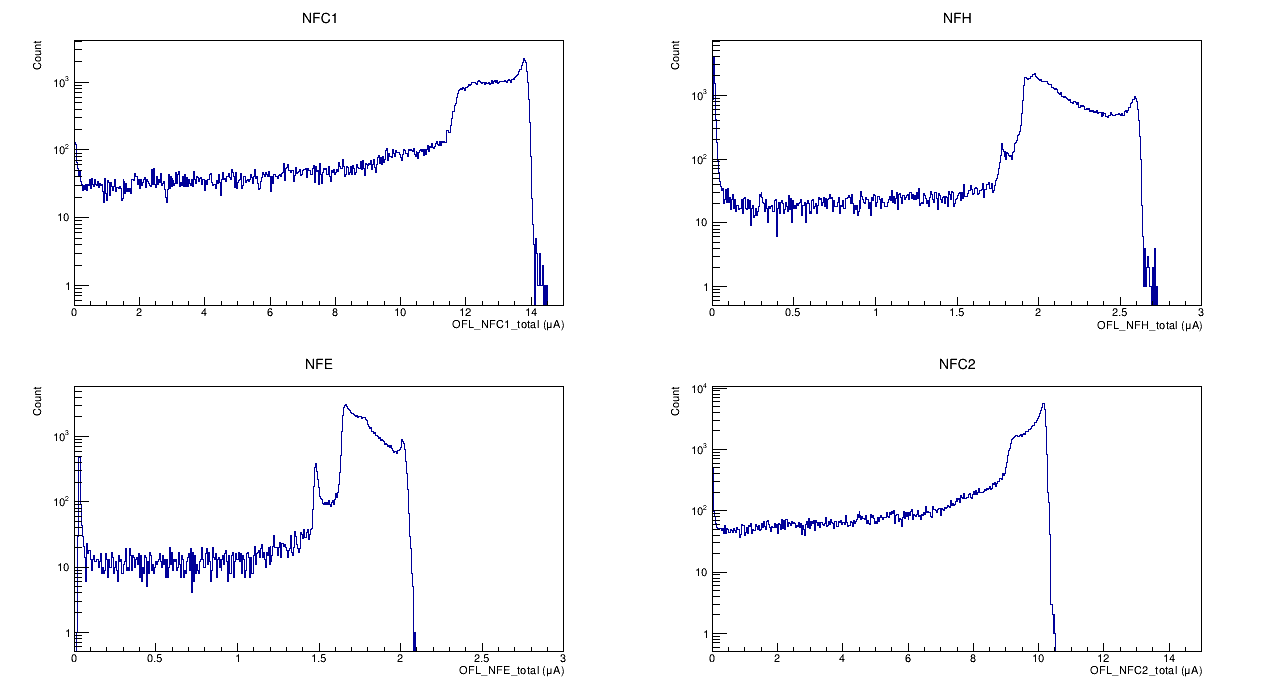

In [6]:
# Create canvas divided into four parts
# .Divide() creates four "pads," which we can draw histograms on
multi1DCanvas = ROOT.TCanvas("multi1DCanvas", "", 1280, 720)
multi1DCanvas.Divide(2,2)
# Plots aren't actually drawn until we call .Draw() on the canvas,
# so we need every histogram alive when that call is made; we can't
# overwrite old histograms in a loop.  We'll accumulate them all in
# a dictionary.
hists1D = {}
# Names and bins for each detector
# (ROOT calls these "models")
detectors = ["NFC1", "NFH", "NFE", "NFC2"]
models1D = {
    detectors[0]: (detectors[0], "NFC1", 500, 0, 15),
    detectors[1]: (detectors[1], "NFH" , 500, 0,  3),
    detectors[2]: (detectors[2], "NFE" , 500, 0,  3),
    detectors[3]: (detectors[3], "NFC2", 500, 0, 15)
}
# Loop over detectors to draw a histogram for each
for i, detector in enumerate(detectors, start=1):
    # Create histogram
    hists1D[detector] = df.Filter(f"trig_ch == {i}",f'trig_{detector}')\
                          .Histo1D(models1D[detector], f"OFL_{detector}_total")
    
for i, detector in enumerate(detectors, start=1):
    # Select the appropriate pad and make it logarithmic
    # (.cd(i) activates pad number i and also returns it)
    multi1DCanvas.cd(i).SetLogy()
    hists1D[detector].SetStats(0)
    hists1D[detector].GetXaxis().SetTitle("\\hbox{{OFL_{}_total (μA)}}".format(detector))
    hists1D[detector].GetYaxis().SetTitle("Count")
    # "Draw" this histogram
    # (more like queuing it up for when we call .Draw() on the canvas)
    hists1D[detector].Draw()
# Render it all
multi1DCanvas.Draw()

# Single 2D Histogram

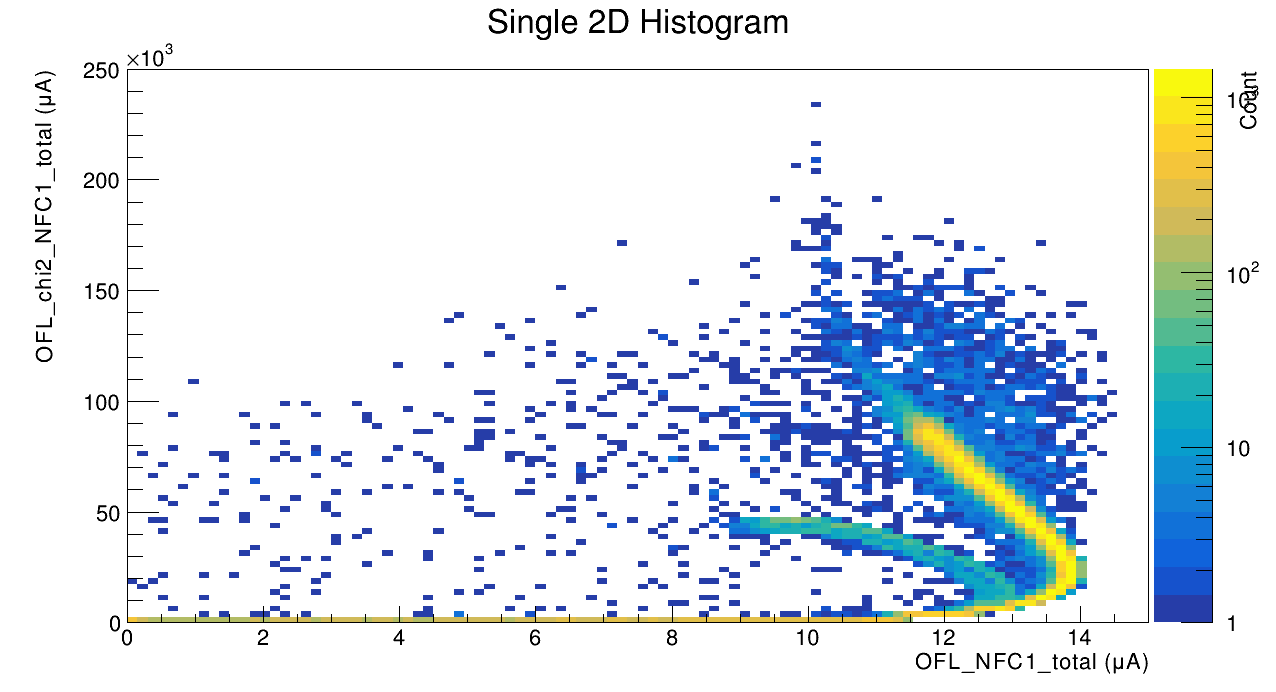

In [7]:
# Create canvas with colour scale (z-axis) logarithmic
single2DCanvas = ROOT.TCanvas("single2DCanvas", "", 1280, 720)
single2DCanvas.SetLogz()

# Create 2D histogram with OFL_NFC1_total on x and OFL_ch2_NFC1_total on y
single2DHist = df.Filter(f"trig_ch == 1",f'trig_NFC1').Histo2D(
    ("single2DHist", "Single 2D Histogram", 100, 0, 15, 100, 0, 250_000),
    "OFL_NFC1_total",
    "OFL_chi2_NFC1_total"
)

single2DHist.SetStats(0) # Stat box covers colour scale

single2DHist.GetXaxis().SetTitle("\\hbox{OFL_NFC1_total (μA)}")
single2DHist.GetYaxis().SetTitle("\\hbox{OFL_chi2_NFC1_total (μA)}")
single2DHist.GetZaxis().SetTitle("Count")
single2DHist.GetZaxis().SetTitleOffset(0.5) # Stupid thing is drawn offscreen otherwise...

# Draw histogram
single2DHist.Draw("colz") # Default style is for greyscale printing; "colz" style is what we expect
single2DCanvas.Draw()

# Many 2D Histograms

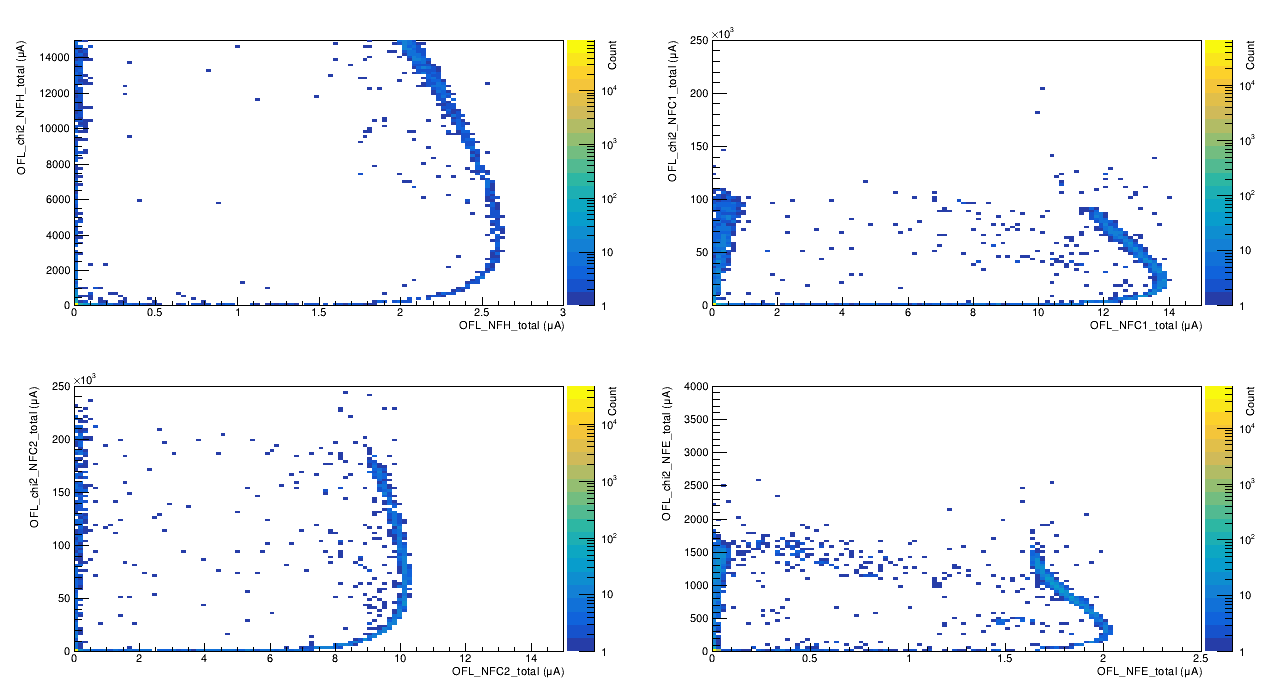

In [8]:
# Create divided canvas
multi2DCanvas = ROOT.TCanvas("multi2DCanvas", "", 1280, 720)
multi2DCanvas.Divide(2,2)

# Dictionary of histograms
hists2D = {}

# Names/bins per detector
detectors = ["NFH", "NFC1", "NFC2", "NFE"]
models2D = {
    detectors[0]: (detectors[0], "", 100, 0,  3.0, 100, 0,  15_000),
    detectors[1]: (detectors[1], "", 100, 0, 15.0, 100, 0, 250_000),
    detectors[2]: (detectors[2], "", 100, 0, 15.0, 100, 0, 250_000),
    detectors[3]: (detectors[3], "", 100, 0,  2.5, 100, 0,   4_000)
}

# Draw histogram for each detector
for i, detector in enumerate(detectors, start=1):
    # Create histogram
    hists2D[detector] = df.Filter(f"trig_ch == {i}",f'trig_{detector}')\
                          .Histo2D(models2D[detector],f"OFL_{detector}_total",f"OFL_chi2_{detector}_total")

    
# df.Cache(['trig_ch','OFL_NFC1_total',....])

for i, detector in enumerate(detectors, start=1):
    # Select pad and make it logarithmic
    multi2DCanvas.cd(i).SetLogz()
    hists2D[detector].SetStats(0)
    hists2D[detector].GetXaxis().SetTitle("\\hbox{{OFL_{}_total (μA)}}".format(detector))
    hists2D[detector].GetYaxis().SetTitle("\\hbox{{OFL_chi2_{}_total (μA)}}".format(detector))
    hists2D[detector].GetZaxis().SetTitle("Count")
    hists2D[detector].GetZaxis().SetTitleOffset(0.5)

    # "Draw" histogram
    hists2D[detector].Draw("colz")

# Render it all
multi2DCanvas.Draw()

In [9]:
cut_base = """
bool OFL_cut_%s(long double x) {
    return x<%s;
}
"""

values = {}
values['NFC1'] = 5
values['NFC2'] = 5
values['NFH'] = 1
values['NFE'] = 1
for det in tr:
    cut = cut_base%(det,values[det])
    print(f'{det}: {cut}') 
    ROOT.gInterpreter.Declare(cut)

NFC1: 
bool OFL_cut_NFC1(long double x) {
    return x<5;
}

NFH: 
bool OFL_cut_NFH(long double x) {
    return x<1;
}

NFE: 
bool OFL_cut_NFE(long double x) {
    return x<1;
}

NFC2: 
bool OFL_cut_NFC2(long double x) {
    return x<5;
}



In [10]:
def limit_cut_factory(limit):
    def limit_cut(x):
        return x<limit
    return limit_cut

In [11]:
for ch,limit in values.items():
    cut_name = f"OFL_cut_{ch}"
    cut = limit_cut_factory(limit)
    ROOT.Numba.Declare(['double'], 'bool', name=cut_name)(cut)

## Explicit declaration of numba functions

Not executed, just for reference

```python
@ROOT.Numba.Declare(['double'], 'bool')
def OFL_cut_NFC1(  x):
    return x<5;

@ROOT.Numba.Declare(['double'], 'bool')
def OFL_cut_NFH(  x):
    return x<1;

@ROOT.Numba.Declare(['double'], 'bool')
def OFL_cut_NFE( x) :
    return x<1;


@ROOT.Numba.Declare(['double'], 'bool')
def OFL_cut_NFC2( x) :
    return x<5;
```

Warning in <TCanvas::Constructor>: Deleting canvas with same name: multi2DCanvas


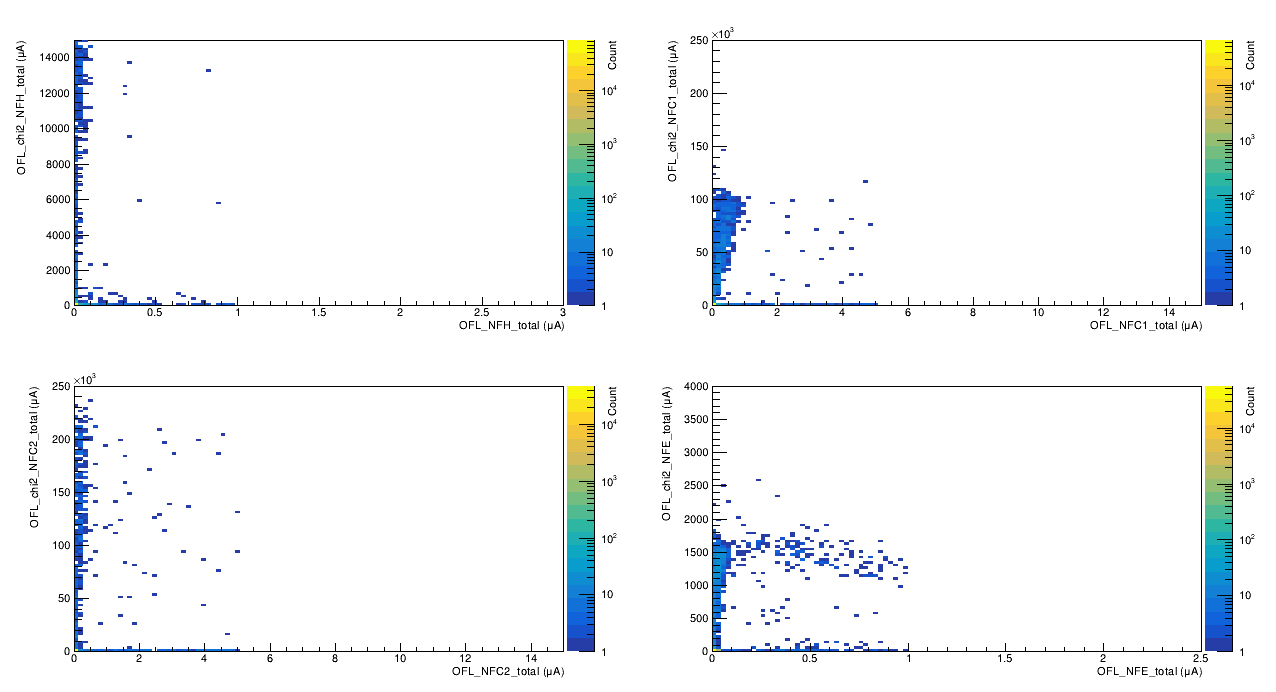

In [12]:
df = ROOT.RDataFrame('rqDir/zip1',files)
# Create divided canvas
multi2DCanvas = ROOT.TCanvas("multi2DCanvas", "", 1280, 720)
multi2DCanvas.Divide(2,2)

# Dictionary of histograms
hists2D = {}

# Names/bins per detector
detectors = ["NFH", "NFC1", "NFC2", "NFE"]
models2D = {
    detectors[0]: (detectors[0], "", 100, 0,  3.0, 100, 0,  15_000),
    detectors[1]: (detectors[1], "", 100, 0, 15.0, 100, 0, 250_000),
    detectors[2]: (detectors[2], "", 100, 0, 15.0, 100, 0, 250_000),
    detectors[3]: (detectors[3], "", 100, 0,  2.5, 100, 0,   4_000)
}

# Draw histogram for each detector
for i, detector in enumerate(detectors, start=1):
    # Create histogram
    hists2D[detector] = df.Filter(f"trig_ch == {i}",f'trig_{detector}')\
                          .Filter(f'Numba::OFL_cut_{detector}(OFL_{detector}_total)',f'energy_cut_{detector}')\
                          .Histo2D(models2D[detector],f"OFL_{detector}_total",f"OFL_chi2_{detector}_total")

for i, detector in enumerate(detectors, start=1):
    # Select pad and make it logarithmic
    multi2DCanvas.cd(i).SetLogz()

    hists2D[detector].SetStats(0)
    hists2D[detector].GetXaxis().SetTitle("\\hbox{{OFL_{}_total (μA)}}".format(detector))
    hists2D[detector].GetYaxis().SetTitle("\\hbox{{OFL_chi2_{}_total (μA)}}".format(detector))
    hists2D[detector].GetZaxis().SetTitle("Count")
    hists2D[detector].GetZaxis().SetTitleOffset(0.5)

    # "Draw" histogram
    hists2D[detector].Draw("colz")

# Render it all
multi2DCanvas.Draw()

In [13]:
All_cuts = df.Report()
All_cuts.Print()  

trig_NFH  : pass=102256     all=796516     -- eff=12.84 % cumulative eff=12.84 %
energy_cut_NFH: pass=100922     all=102256     -- eff=98.70 % cumulative eff=12.67 %
trig_NFC1 : pass=131480     all=796516     -- eff=16.51 % cumulative eff=16.51 %
energy_cut_NFC1: pass=130157     all=131480     -- eff=98.99 % cumulative eff=16.34 %
trig_NFC2 : pass=103058     all=796516     -- eff=12.94 % cumulative eff=12.94 %
energy_cut_NFC2: pass=101871     all=103058     -- eff=98.85 % cumulative eff=12.79 %
trig_NFE  : pass=125300     all=796516     -- eff=15.73 % cumulative eff=15.73 %
energy_cut_NFE: pass=124045     all=125300     -- eff=99.00 % cumulative eff=15.57 %


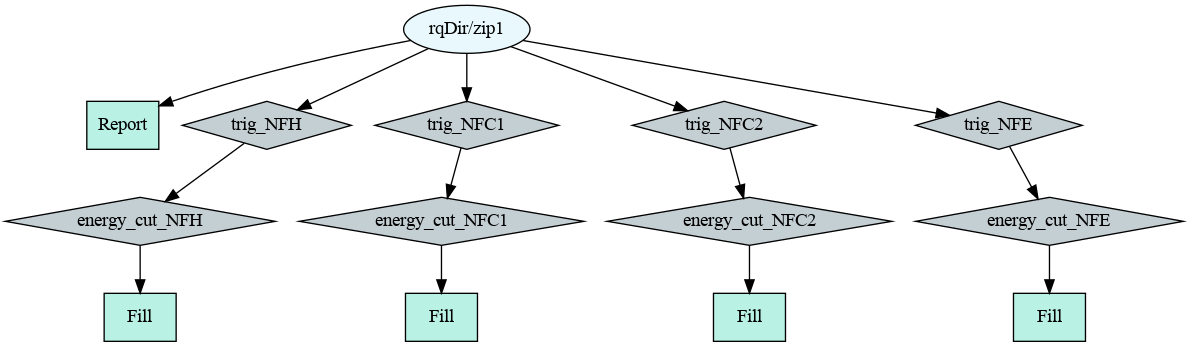

In [14]:
# Computational graph ...
ROOT.RDF.SaveGraph(df, "./mydot1.dot");
!dot -Tpng mydot1.dot -ocomputation_graph1.png
Image("./computation_graph1.png")